In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_dataset import *
from utils.transforms import *
from detection.detector_utils import *
from detection.dummy_albu_mapper import *

import cv2
from glob import glob
import os
import re
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import json, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data import transforms as T

import glob
from PIL import Image, ImageDraw


Populating the interactive namespace from numpy and matplotlib


In [2]:
DatasetImages = PreprocessedDatasetFull()

Part 1 length  376
Part 2 length  249


In [3]:
data_list_FS = DatasetImages.make_in_memory_dataset('ill', 'cor', ['STIR', 'FS', 'TRIM', 'fs', 'DARK', 'SPAIR', 'stir'],
                                                    drop_types = ['DIRTY', 'SPINE','PELVIS' ] , crop=False, best_slice=False, resize=False )

data_list = data_list_FS

133  dataset length


In [2]:
DatasetImages = PreprocessedDatasetPart1()

data_list_FS = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD_FS', 'T1_FS', 'T2_FS', 'STIR', 'TRIM', 'T1_DARK', 'SPAIR', 'T2_DARK', 'PD_DARK' ]
                                                    , drop_types = ['DIRTY', 'SPINE','PELVIS' ] , crop=False, best_slice=False, resize=False ,stack_images=False)
DATASET_NAME = 'joints_large_FS'
DATASET_PATH = 'detection/data/cor_large_FS'
MODEL_NAME = 'Detector_LARGE_FS.pth'

#data_list_Full = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD', 'T1', 'T2', 'STIR',], drop_types = ['DIRTY'] , crop=False, best_slice=False, resize=False ,stack_images=False)
#data_list_FS = DatasetImages.make_in_memory_dataset(task, projection, researh_types, drop_types, crop=True, best_slice=True, resize=False )    

#data_list_Light = DatasetImages.make_in_memory_dataset('ill', 'cor', ['PD', 'T1', 'T2'], drop_types = ['DIRTY', 'STIR', 'FS', 'TRIM', 'fs', 'DARK', 'SPAIR', 'SPINE', 'NF'] , crop=False, best_slice=False, resize=False ,stack_images=False)
#DATASET_NAME = 'joints_large_Full'
#DATASET_PATH = 'detection/data/cor_large_L'
#MODEL_NAME = 'Detector_LARGE_UNI.pth'

data_list = data_list_FS

133  dataset length


In [15]:
i = 150
images = data_list[i]['images']
path = data_list[i]['path']
best_slice = data_list[i]['best_slice'] 
box = np.array(data_list[i]['box'])
image = images[best_slice].copy()
image = image[0,:,:]
print(data_list[i]['researh_type'])
print(data_list[i]['path'])
print(len(images))
color = (255, 0, 0)  
thickness = 2  
image = cv2.rectangle(image,  (box[0], box[1]) , (box[2],box[3]),  color, thickness)
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(image)
plt.show()


IndexError: list index out of range

In [4]:
def dataset_format_train():    
    dataset = dataset_train       
    return dataset    

def dataset_format_val():    
    dataset = dataset_val       
    return dataset    
  

In [5]:
dataset_train, dataset_val = make_jpeg_dataset(data_list, base_path = DATASET_PATH, images_already_exist = False)

In [6]:
#with open('detection/dataset_train.json', 'w') as fp:
#    json.dump(dataset_train, fp)
#with open('detection/dataset_val.json', 'w') as fp:
#    json.dump(dataset_train, fp)

#with open('detection/dataset_train.json') as json_file:
#    dataset_train = json.load(json_file) 
#with open('detection/dataset_val.json') as json_file:
#    dataset_val = json.load(json_file)

In [7]:
#!rm detection/data/cor/*.jpg

In [8]:
DatasetCatalog.register(DATASET_NAME + "_train", dataset_format_train)
DatasetCatalog.register(DATASET_NAME + "_val", dataset_format_val) 

MetadataCatalog.get(DATASET_NAME + "_train").thing_classes = ["joint"]
MetadataCatalog.get(DATASET_NAME + "_val").thing_classes = ["joint"]

joints_metadata = MetadataCatalog.get(DATASET_NAME + "_train")

In [9]:
#DatasetCatalog.remove(DATASET_NAME + "_train")
#DatasetCatalog.remove(DATASET_NAME + "_val")

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader, build_detection_test_loader


class Trainer(DefaultTrainer):
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations= [
                                                                      T.RandomBrightness(0.8, 1.2),
                                                                      #T.HFlipTransform(), 
                                                                                                          ], ))

In [11]:
#detection/model_final_971ab9.pkl
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATASETS.TRAIN = (DATASET_NAME + "_train",)
cfg.DATASETS.TEST = (DATASET_NAME + "_val",)
#cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 10
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)

Loading config /home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/17 01:08:19 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [12]:
trainer.train()

[07/17 01:08:19 d2.engine.train_loop]: Starting training from iteration 0


/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[07/17 01:08:29 d2.utils.events]:  eta: 0:07:39  iter: 19  total_loss: 1.174  loss_cls: 0.6727  loss_box_reg: 0.4948  time: 0.5031  data_time: 0.0218  lr: 2.9971e-06  max_mem: 2593M
[07/17 01:08:34 d2.utils.events]:  eta: 0:06:56  iter: 39  total_loss: 1.349  loss_cls: 0.7626  loss_box_reg: 0.5846  time: 0.3513  data_time: 0.0017  lr: 5.9941e-06  max_mem: 2593M
[07/17 01:08:37 d2.utils.events]:  eta: 0:03:54  iter: 59  total_loss: 1.245  loss_cls: 0.6705  loss_box_reg: 0.5863  time: 0.2932  data_time: 0.0018  lr: 8.9911e-06  max_mem: 2593M
[07/17 01:08:41 d2.utils.events]:  eta: 0:02:36  iter: 79  total_loss: 1.175  loss_cls: 0.5742  loss_box_reg: 0.5529  time: 0.2633  data_time: 0.0016  lr: 1.1988e-05  max_mem: 2593M
[07/17 01:08:43 d2.utils.events]:  eta: 0:02:09  iter: 99  total_loss: 1.023  loss_cls: 0.4738  loss_box_reg: 0.5448  time: 0.2374  data_time: 0.0016  lr: 1.4985e-05  max_mem: 2593M
[07/17 01:08:47 d2.utils.events]:  eta: 0:02:06  iter: 119  total_loss: 0.8931  loss_cls: 

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(DATASET_NAME + "_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, DATASET_NAME + "_val", mapper=None)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/17 01:11:20 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/17 01:11:20 d2.evaluation.coco_evaluation]: 'joints_large_FS_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/17 01:11:20 d2.data.datasets.coco]: Converting annotations of dataset 'joints_large_FS_val' to COCO format ...)
[07/17 01:11:20 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/17 01:11:20 d2.data.datasets.coco]: Conversion finished, #images: 28, #annotations: 28
[07/17 01:11:20 d2.data.datasets.coco]: Caching COCO format annotations at './output/joints_large_FS_val_coco_format.json' ...
[07/17 01:11:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/17 01:11:20 d2.data.common]: Serializing 28 elements to byte te

OrderedDict([('bbox',
              {'AP': 30.082762488301316,
               'AP50': 63.39392611850643,
               'AP75': 22.38952665745588,
               'APs': nan,
               'APm': 40.2090209020902,
               'APl': 38.67427487505445})])

In [37]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

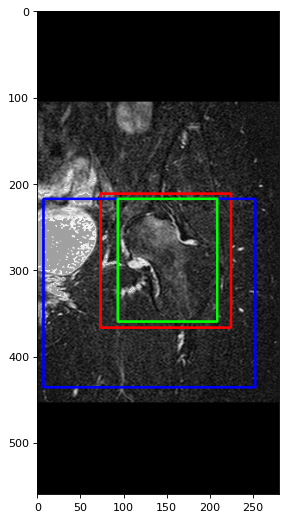

[ 73.031105 212.982    224.43861  367.78302 ]


In [74]:
color = (255, 0, 0)  
t_color = (0, 255, 0)  
s_color = (0, 0, 255)  

thickness = 2  
dataset_dicts = dataset_val

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]
    pred_boxes2 = outputs["instances"].to("cpu").pred_boxes[1].tensor.numpy()[0]

    true_boxes = d['annotations'][0]['bbox']
    image = cv2.rectangle(im,  (int(pred_boxes[0]), int(pred_boxes[1])) , (int(pred_boxes[2]),int(pred_boxes[3])),  color, thickness)
    image = cv2.rectangle(im,  (int(pred_boxes2[0]), int(pred_boxes2[1])) , (int(pred_boxes2[2]),int(pred_boxes2[3])),  s_color, thickness)

    image = cv2.rectangle(image,  (int(true_boxes[0]), int(true_boxes[1])) , (int(true_boxes[2]),int(true_boxes[3])),  t_color, thickness)
    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)

In [104]:
def if_small(box, image):
    
    startX, startY, endX, endY = box
    
    s_box = (endX - startX )* (endY - startY) 
    s_image = image.shape[0] * image.shape[1]
    if s_box/s_image > 0.1:    
        return True
    else: 
        return False
    

False


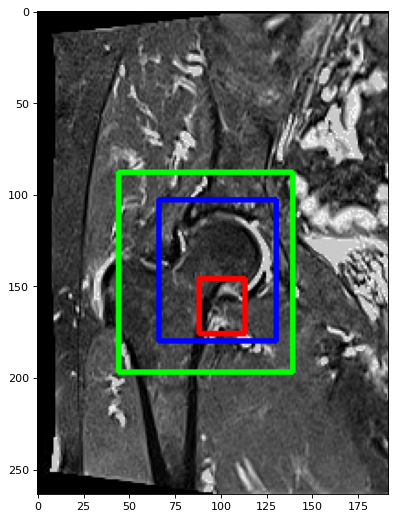

[ 88.764275 146.1307   113.08972  176.08272 ]
[ 66.076614 103.77618  130.42128  180.16687 ]


In [105]:
color = (255, 0, 0)  
t_color = (0, 255, 0)  
s_color = (0, 0, 255)  

thickness = 2  
dataset_dicts = dataset_val

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]
    pred_boxes2 = outputs["instances"].to("cpu").pred_boxes[1].tensor.numpy()[0]

    true_boxes = d['annotations'][0]['bbox']
    
    print(if_small(pred_boxes, im))
    image = cv2.rectangle(im,  (int(pred_boxes[0]), int(pred_boxes[1])) , (int(pred_boxes[2]),int(pred_boxes[3])),  color, thickness)
   
    image = cv2.rectangle(im,  (int(pred_boxes2[0]), int(pred_boxes2[1])) , (int(pred_boxes2[2]),int(pred_boxes2[3])),  s_color, thickness)

    image = cv2.rectangle(image,  (int(true_boxes[0]), int(true_boxes[1])) , (int(true_boxes[2]),int(true_boxes[3])),  t_color, thickness)
    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)
    print(pred_boxes2)

In [95]:
pred_boxes

array([ 49.19608,  90.75101, 134.9503 , 180.31607], dtype=float32)

In [45]:
n=

SyntaxError: invalid syntax (<ipython-input-45-52c061e5106c>, line 1)

In [ ]:
pred_boxes

## Small Crop

In [ ]:
annotation_path = 'detection/Smal_Crop/annotations.json'

with open(annotation_path) as json_file:
    annotation_data = json.load(json_file)
print('masks: ',len(list(annotation_data.keys())))
filenames_list = glob.glob('detection/Smal_Crop/images/*.png')
print('images: ', len(filenames_list))

In [ ]:
def get_box(box):    
    
    startX = box['x1']
    startY = box['y1'] 
    endX = box['x2']
    endY  = box['y2']
    box = [startX, startY, endX, endY]
    
    return box  
      
def resize_new_box(orginal_image, old_box, box):     
    
    startX, startY, endX, endY = box
    startX -= old_box[0]
    endX -= old_box[0]
    startY -= old_box[1]
    endY -= old_box[1]
    resized_box = [startX, startY, endX, endY]    
    
    return resized_box

def get_npy_file(element, path = './data'):  
    
    name = element['path'].split('/')[-1].split('.')[0]
    npy_file_path = os.path.join(path,name + '.npy')
    images = np.load(npy_file_path, allow_pickle=True)
    
    return images, npy_file_path  


In [ ]:
crops_dataset_raw = {}

for file in filenames_list:
    png_name = file.split('/')[-1]
    if png_name in list(annotation_data.keys()):
        element = {}
        orig_image = Image.open(file)
        width, height = orig_image.size
        img = Image.new('L', (width, height), 0)
        instances = annotation_data[png_name]['instances']
        for instance in instances:
            box = get_box(instance['points'])
        element['box'] = box
        element['path'] = file
        element['image'] = orig_image
        _ , npy_path = get_npy_file(element)
        
        crops_dataset_raw[npy_path] = element      


In [ ]:

                                               
    
def prepare_detection_dataset(crops_dataset_raw, projection, task, drop_researh_tags=['DIRTY'], researh_type=None, conjunction=True, resize=True, dim=(256, 256),best_slice = False, with_images = False):
    
    marking = pd.read_csv('labels/marking_arrays_v2.csv', usecols=['path', 'parent path', 'patient number',
                                                                'researh type', 'projection', 'hip side',
                                                                'cartialge lesion',
                                                                'subchondral cysts', 'bone marrow lesion', 'synovitis',
                                                                'ill', 'best_slice', 'bad_research', 'rectangle'])
    

    bad_mark = '-'
    proc_marking = marking[marking['bad_research'] != bad_mark]
    proc_marking = proc_marking[proc_marking['projection'] == projection]
    if researh_type:
        if conjunction:
            proc_marking_1 = proc_marking[proc_marking['researh type'].str.contains(researh_type[0], na=False)]
            proc_marking_2 = proc_marking[proc_marking['researh type'].str.contains(researh_type[1], na=False)]
            proc_marking_3 = proc_marking[proc_marking['researh type'].str.contains(researh_type[2], na=False)]
            proc_marking  = pd.concat([proc_marking_1, proc_marking_2,  proc_marking_3])
            proc_marking = proc_marking.drop_duplicates()
        elif not conjunction:  
            proc_marking = proc_marking[proc_marking['researh type'].str.contains(researh_type[0], na=False) & proc_marking['researh type'].str.contains(researh_type[1], na=False)]


    for tag in drop_researh_tags:
        mask = proc_marking['researh type'].str.contains(tag, na=False)
        proc_marking = proc_marking[~mask]

    data_dict = {}
    length = 0
    new_keys = list(crops_dataset_raw.keys())
    
    for i, row in enumerate(proc_marking.iloc):
        label = {}
        data = {}

        path = row['path']
        raw_row = row['rectangle']
        box = re.findall(r"\d+", raw_row)
        integer_map = map(int, box)
        box = list(integer_map)
        try:
            images = np.load(path[2:], allow_pickle=True)
        except ValueError:
            print('not loaded ', path)
        else:
            if len(images.shape )>2:

                data['label'] = int(row[task])
                
                if path in new_keys:
                    new_box = crops_dataset_raw[path]['box']                
                    data['bb_box'] = new_box
                    data['bb_box_large'] = box
                else:
                    continue
                    
                
                
                if best_slice:                    
                    slice = int(row['best_slice'])
                    images = slice_crop(images, 0.1, slice)
                if resize:
                    images = resize_cv2(images, dim)

                images = normalize_images_v1(images)     
                
                
                #data['image'] = images
                data['image'] = crop_images(images, box)
                data['bb_box'] = resize_new_box(images, box, data['bb_box'] )
                
                data['path'] = path
                data['best_slice'] = int(row['best_slice'])
                data_dict[path] = data                
                length += 1
                
    print('dataset len', length)
    assert len(list(data_dict.keys()))==length
    return length, data_dict

In [ ]:
_, data_dict = prepare_detection_dataset(crops_dataset_raw, 'cor', 'ill',
                             drop_researh_tags=['DIRTY'],
                             researh_type=['PD', 'T1', 'T2', 'STIR'], 
                             conjunction=True, resize=False,
                             dim=(512, 512), best_slice = False, with_images = True )

In [ ]:
i = 4
keys = list(data_dict.keys())
key = keys[i]
images = data_dict[key]['image']
path = data_dict[key]['path']
best_slice = data_dict[key]['best_slice']   
box = np.array(data_dict[key]['bb_box'])
#box_large = np.array(data_dict[key]['bb_box_large'])

image = images[best_slice].copy()
print(image.shape)

color = (255, 0, 0)  
thickness = 2  
image = cv2.rectangle(image,  (int(box[0]), int(box[1])) , (int(box[2]),int(box[3])),  color, thickness)
#image = cv2.rectangle(image,  (int(box_large[0]), int(box_large[1])) , (int(box_large[2]),int(box_large[3])),  color, thickness)

figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(image)
plt.show()
print(box)

In [ ]:
def make_jpeg_dataset(data_dict):
    base_path = 'detection/data/cor/'
    index = 0    
    keys = list(data_dict.keys())
    dataset_train = []
    for key in keys[:int(len(keys)*0.9)]:
        
        images = data_dict[key]['image']        
        best_slice = data_dict[key]['best_slice']   
        bbox = {'bbox': data_dict[key]['bb_box'], 'bbox_mode': BoxMode.XYXY_ABS, 'category_id':0}     
        for i in [-2,-1,0,1, 2]:
            
            element = dict()
            current_slice = best_slice+i
            if current_slice<0:
                current_slice =0
            image = images[current_slice]        
            filename = os.path.join(base_path, '{}_slice.jpg'.format(index))        
            cv2.imwrite(filename, image)
            element['file_name'] = filename
            element['height'] = image.shape[0]
            element['width'] = image.shape[1]
            element['image_id'] = index 
            element['annotations'] = []    
               
            element['annotations'].append(bbox)
            dataset_train.append(element)
            index += 1
            
    dataset_val = []
    for key in keys[int(len(keys)*0.9):]:
        
        images = data_dict[key]['image']        
        best_slice = data_dict[key]['best_slice']   
        bbox = {'bbox': data_dict[key]['bb_box'], 'bbox_mode': BoxMode.XYXY_ABS, 'category_id':0}     
        for i in [-1,0,1]:
            
            element = dict()
            current_slice = best_slice+i
            if current_slice<0:
                current_slice =0
            image = images[current_slice]        
            filename = os.path.join(base_path, '{}_slice.jpg'.format(index))        
            cv2.imwrite(filename, image)
            element['file_name'] = filename
            element['height'] = image.shape[0]
            element['width'] = image.shape[1]
            element['image_id'] = index 
            element['annotations'] = []    
               
            element['annotations'].append(bbox)
            dataset_val.append(element)
            index += 1

    return dataset_train, dataset_val

In [ ]:
def dataset_format_example():
    
    keys = list(data_dict.keys())
    dataset = []
    i = 0
    for key in keys:
        i += 1
        element = dict()
        element['file_name'] = data_dict[key]['path']
        element['height'] = data_dict[key]['image'].shape[0]
        element['width'] = data_dict[key]['image'].shape[1]
        element['image_id'] = i        
        element['annotations'] = []        
        bbox = {'bbox': data_dict[key]['bb_box'], 'bbox_mode': BoxMode.XYXY_ABS, 'category_id':0}
        
        element['annotations'].append(bbox)
        dataset.append(element)
        
    return dataset    

def dataset_format_train():    
    dataset = dataset_train       
    return dataset    

In [ ]:
DatasetCatalog.remove("joints_train")


In [ ]:
dataset_train, dataset_val = make_jpeg_dataset(data_dict)

DatasetCatalog.register("joints_train", dataset_format_train)

#data = DatasetCatalog.get("joints_train")

from detectron2.data import MetadataCatalog

MetadataCatalog.get("joints_train").thing_classes = ["joint"]

joints_metadata = MetadataCatalog.get("joints_train")

In [ ]:
from detectron2.engine import DefaultTrainer
#detection/model_final_971ab9.pkl
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATASETS.TRAIN = ("joints_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
color = (255, 0, 0)  
color2 = (0, 255, 0)  

thickness = 2  
dataset_dicts = dataset_train

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    pred_boxes = np.uint8(outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0])
    pred_boxes2 = np.uint8(outputs["instances"].to("cpu").pred_boxes[1].tensor.numpy()[0])

    image = cv2.rectangle(im,  (pred_boxes[0], pred_boxes[1]) , (pred_boxes[2],pred_boxes[3]),  color, thickness)
    #image = cv2.rectangle(im,  (pred_boxes2[0], pred_boxes2[1]) , (pred_boxes2[2],pred_boxes2[3]),  color2, thickness)

    figure(figsize=(8, 8), dpi=80)
    imgplot = plt.imshow(image)
    plt.show()

    print(pred_boxes)

In [ ]:
outputs